# Exploratory Data Analysis Pt 2

## Model Activations

In this second part of the EDA, I'm taking a look at the data produced by [Essentia's models](https://essentia.upf.edu/models.html)

In [32]:
#Imports
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
from tqdm import tqdm
import pathlib
import librosa
import taglib
from IPython.lib.display import YouTubeVideo
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
pd.set_option('max_colwidth', 100)

In [2]:
#Imports from project package called project_tools
from project_tools.utils import adapt_array, convert_array, tag_cleaner, json_opener

In [3]:
#Register these functions with sqlite3 so that we I can work with 
sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

In [4]:
#Connect to db
conn = sqlite3.connect("../jaage.db", detect_types= sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

Here are the tables in my database

In [5]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", con = conn)
tables

,name
0,effnet_embeddings
1,tonal_features
2,lowlevel_features
3,rhythm_features
4,approachability_2c_effnet_discogs_1_activations
5,danceability_effnet_discogs_1_activations
6,engagement_2c_effnet_discogs_1_activations
7,genre_electronic_effnet_discogs_1_activations
8,mood_acoustic_effnet_discogs_1_activations
9,mood_aggressive_effnet_discogs_1_activations


Load in tags data as well 

In [6]:
tags = pd.read_sql_query("SELECT * FROM tags", con = conn).set_index("sid")
tags.head()

,length,gain,codec,file_name,bpm,initialkey,title,album,artist,date,genre,label
sid,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,287.393372,-9.895140,pcm_s16le,04 House Of Love_PN.wav,119.0,6A,04 House Of Love_PN,None,None,None,None,None
46e54d2ab920a088b77382e04877141b,311.251892,-11.281836,pcm_s16le,Alex Virgo - Rough N' Ready Edits - 06 A.T.S - Baa Daa Laa (Alex Virgo's Rough n Ready edit)_PN.wav,128.0,1A,A.T.S - Baa Daa Laa (Alex Virgo's Rough n Ready edit),Rough N' Ready Edits,Alex Virgo,2020,None,None
a204ddef5763df6d8f7677701fe9d96f,415.114746,-9.958479,pcm_s16le,01 Protostar_PN.wav,117.0,5A,Protostar,Planetary Groove,FROM BEYOND,2020,None,None
960097894e83c5810a9c649f17a4e551,321.108765,-12.223524,pcm_s16le,Cristal - Drink My Soul (Running Hot Edit)_PN.wav,0.0,None,None,None,None,None,None,None
a3c1f277aa0110ffc418bf5fa3aa16aa,378.276276,-12.410757,pcm_s16le,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN.wav,109.0,6A,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN,None,None,2016,None,None


In [7]:
activations_tables = tables[tables.name.str.contains("activations") ].name.tolist()
activations_tables

['approachability_2c_effnet_discogs_1_activations',
 'danceability_effnet_discogs_1_activations',
 'engagement_2c_effnet_discogs_1_activations',
 'genre_electronic_effnet_discogs_1_activations',
 'mood_acoustic_effnet_discogs_1_activations',
 'mood_aggressive_effnet_discogs_1_activations',
 'mood_happy_effnet_discogs_1_activations',
 'mood_party_effnet_discogs_1_activations',
 'mood_sad_effnet_discogs_1_activations',
 'mtg_jamendo_genre_effnet_discogs_1_activations',
 'mtg_jamendo_moodtheme_effnet_discogs_1_activations',
 'mtg_jamendo_top50tags_effnet_discogs_1_activations',
 'timbre_effnet_discogs_1_activations']

Add the effnet genre activations as well

In [8]:
activations_tables += ['effnet_genres']

Going into this project I was bullish that these models could accurately appraise certain acoustic qualities and traits in music but I was always going to need to apply an ear test to see how well they work on my music collection.

In this notebook I go through each of model activations and assess how well they are rating how "happy" or "aggressive" a song is or how good they are are identifying obscure genres of music.

### [Effnet Genres](https://essentia.upf.edu/models.html#discogs-effnet)

"Prediction of the top-400 music styles in the Discogs-4M dataset (unreleased)",

[Model metadata](https://essentia.upf.edu/models/music-style-classification/discogs-effnet/discogs-effnet-bs64-1.json)

In [9]:
effnet_genres = pd.read_sql_query("SELECT * FROM effnet_genres", 
                                  con = conn).set_index("sid").applymap(lambda x:x[0])
effnet_genres.head()

,blues___boogie_woogie,blues___chicago_blues,blues___country_blues,blues___delta_blues,blues___electric_blues,blues___harmonica_blues,blues___jump_blues,blues___louisiana_blues,blues___modern_electric_blues,blues___piano_blues,...,rock___symphonic_rock,rock___technical_death_metal,rock___thrash,rock___twist,rock___viking_metal,rock___yé_yé,stage__screen___musical,stage__screen___score,stage__screen___soundtrack,stage__screen___theme
sid,,,,,,,,,,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,"[4.172325e-07, 1.4007092e-06, 7.1525574e-07, 4.7683716e-07, 2.9802322e-07, 9.834766e-07, 6.85453...","[8.046627e-06, 1.7791986e-05, 9.953976e-06, 1.2457371e-05, 5.5134296e-06, 1.5586615e-05, 1.25765...","[6.556511e-07, 3.695488e-06, 3.2782555e-06, 1.9967556e-06, 2.682209e-07, 1.1324883e-06, 1.788139...","[9.23872e-07, 3.9041042e-06, 3.0994415e-06, 1.9073486e-06, 5.9604645e-07, 2.6524067e-06, 3.90410...","[5.155802e-06, 1.5765429e-05, 1.7374754e-05, 1.013279e-05, 3.3676624e-06, 7.867813e-06, 1.886487...","[8.34465e-07, 1.6093254e-06, 6.2584877e-07, 1.8775463e-06, 2.9802322e-07, 1.3411045e-06, 6.85453...","[1.7881393e-07, 5.662441e-07, 8.34465e-07, 3.2782555e-07, 1.7881393e-07, 2.0861626e-07, 4.172325...","[2.682209e-07, 9.834766e-07, 6.2584877e-07, 8.34465e-07, 2.682209e-07, 7.748604e-07, 8.34465e-07...","[1.4424324e-05, 4.7773123e-05, 3.0219555e-05, 6.2674284e-05, 1.04010105e-05, 3.8206577e-05, 2.79...","[1.7881393e-06, 4.2021275e-06, 2.4437904e-06, 4.9471855e-06, 9.834766e-07, 2.0563602e-06, 1.4603...",...,"[6.467104e-06, 3.3050776e-05, 1.13248825e-05, 1.6719103e-05, 3.427267e-06, 1.552701e-05, 9.47713...","[5.9604645e-08, 8.940697e-07, 2.0861626e-07, 5.364418e-07, 8.940697e-08, 4.7683716e-07, 1.192092...","[2.503395e-06, 1.1473894e-05, 4.3809414e-06, 9.000301e-06, 1.2516975e-06, 8.5532665e-06, 4.38094...","[1.9669533e-06, 2.026558e-06, 2.592802e-06, 1.8179417e-06, 1.6987324e-06, 1.5795231e-06, 2.95043...","[1.1920929e-07, 3.5762787e-07, 1.7881393e-07, 2.3841858e-07, 2.9802322e-08, 1.1920929e-07, 5.960...","[3.2782555e-07, 7.748604e-07, 2.3841858e-07, 9.23872e-07, 2.3841858e-07, 7.4505806e-07, 4.172325...","[4.053116e-06, 2.0772219e-05, 4.5895576e-06, 1.0311604e-05, 1.5497208e-06, 6.556511e-06, 4.14252...","[9.447336e-06, 0.00013121963, 1.1473894e-05, 6.315112e-05, 4.3809414e-06, 4.711747e-05, 9.953976...","[0.00019520521, 0.0010717809, 0.0003451407, 0.0005108714, 0.00012162328, 0.00037050247, 0.000285...","[3.707409e-05, 0.00019714236, 0.00012657046, 0.0001604855, 2.8789043e-05, 0.00012040138, 0.00010..."
46e54d2ab920a088b77382e04877141b,"[9.23872e-07, 1.1622906e-06, 5.364418e-07, 7.748604e-07, 1.0728836e-06, 1.5199184e-06, 3.5762787...","[2.1755695e-06, 1.9967556e-06, 9.23872e-07, 6.2584877e-07, 1.5497208e-06, 2.2053719e-06, 1.72853...","[8.940697e-07, 1.937151e-06, 3.5762787e-07, 2.3841858e-07, 6.2584877e-07, 3.0696392e-06, 6.85453...","[2.0861626e-07, 4.4703484e-07, 1.7881393e-07, 1.1920929e-07, 2.3841858e-07, 1.5795231e-06, 1.490...","[5.811453e-06, 3.963709e-06, 3.3080578e-06, 9.23872e-07, 7.2717667e-06, 2.6226044e-06, 5.6028366...","[6.854534e-07, 1.6987324e-06, 6.2584877e-07, 3.5762787e-07, 7.748604e-07, 2.6524067e-06, 5.06639...","[8.6426735e-06, 5.4240227e-06, 3.8444996e-06, 1.1622906e-06, 3.8444996e-06, 2.861023e-06, 4.3213...","[5.9604645e-08, 1.4901161e-07, 5.9604645e-08, 0.0, 1.1920929e-07, 2.3841858e-07, 0.0, 5.9604645e...","[2.3543835e-06, 2.8312206e-06, 2.2351742e-06, 6.854534e-07, 3.0696392e-06, 2.6524067e-06, 3.3080...","[2.9802322e-07, 8.6426735e-07, 2.3841858e-07, 2.9802322e-07, 5.9604645e-08, 1.8179417e-06, 1.192...",...,"[1.5199184e-05, 2.4795532e-05, 1.2069941e-05, 7.897615e-06, 1.5258789e-05, 2.6583672e-05, 1.9043...","[1.937151e-06, 2.8908253e-06, 1.1920929e-06, 1.9669533e-06, 2.503395e-06, 4.1127205e-06, 2.35438...","[3.454089e-05, 2.348423e-05, 1.4036894e-05, 6.8843365e-06, 3.761053e-05, 1.50203705e-05, 4.27067...","[1.6093254e-05, 8.374453e-06, 1.6182661e-05, 7.0631504e-06, 1.5050173e-05, 1.4483929e-05, 1.1503.

In [10]:
song1 = effnet_genres.iloc[0]
song1

blues___boogie_woogie         [4.172325e-07, 1.4007092e-06, 7.1525574e-07, 4.7683716e-07, 2.9802322e-07, 9.834766e-07, 6.85453...
blues___chicago_blues         [8.046627e-06, 1.7791986e-05, 9.953976e-06, 1.2457371e-05, 5.5134296e-06, 1.5586615e-05, 1.25765...
blues___country_blues         [6.556511e-07, 3.695488e-06, 3.2782555e-06, 1.9967556e-06, 2.682209e-07, 1.1324883e-06, 1.788139...
blues___delta_blues           [9.23872e-07, 3.9041042e-06, 3.0994415e-06, 1.9073486e-06, 5.9604645e-07, 2.6524067e-06, 3.90410...
blues___electric_blues        [5.155802e-06, 1.5765429e-05, 1.7374754e-05, 1.013279e-05, 3.3676624e-06, 7.867813e-06, 1.886487...
                                                                             ...                                                 
rock___yé_yé                  [3.2782555e-07, 7.748604e-07, 2.3841858e-07, 9.23872e-07, 2.3841858e-07, 7.4505806e-07, 4.172325...
stage__screen___musical       [4.053116e-06, 2.0772219e-05, 4.5895576e-06, 1.0311604e-05, 

Each song row has an array of N-length whose values representing the activation scores for that model's label. Each value in that row is the score for a small sample for that original song, in this example it represents 2 seconds of data. N is product of the song's length and other settings used in the creation of the spectrograms used to train this and other models.

In [11]:
song1.apply(len)

blues___boogie_woogie         140
blues___chicago_blues         140
blues___country_blues         140
blues___delta_blues           140
blues___electric_blues        140
                             ... 
rock___yé_yé                  140
stage__screen___musical       140
stage__screen___score         140
stage__screen___soundtrack    140
stage__screen___theme         140
Name: b806881a54bdbf9dd93a290716adf191, Length: 400, dtype: int64

Effnet cols are organized by general genre and sub genre

In [12]:
effnet_cols = effnet_genres.columns
effnet_cols

Index(['blues___boogie_woogie', 'blues___chicago_blues',
       'blues___country_blues', 'blues___delta_blues',
       'blues___electric_blues', 'blues___harmonica_blues',
       'blues___jump_blues', 'blues___louisiana_blues',
       'blues___modern_electric_blues', 'blues___piano_blues',
       ...
       'rock___symphonic_rock', 'rock___technical_death_metal',
       'rock___thrash', 'rock___twist', 'rock___viking_metal', 'rock___yé_yé',
       'stage__screen___musical', 'stage__screen___score',
       'stage__screen___soundtrack', 'stage__screen___theme'],
      dtype='object', length=400)

In [13]:
genre_groups = effnet_cols.str.split("___").map(lambda x:x[0]).unique()
genre_groups

Index(['blues', 'brass__military', 'childrens', 'classical', 'electronic',
       'folk_world__country', 'funk__soul', 'hip_hop', 'jazz', 'latin',
       'non_music', 'pop', 'reggae', 'rock', 'stage__screen'],
      dtype='object')

Here is a printed output of the general genre categories and their sub groups

In [14]:
genre_dict = {}

for genre in genre_groups:
    subgenres = effnet_cols[effnet_cols.str.startswith(genre)].str.split("___", expand =True).get_level_values(1).tolist()
    genre_dict[genre] = subgenres

In [15]:
for k, v in genre_dict.items():
    print(k, v, "\n")

blues ['boogie_woogie', 'chicago_blues', 'country_blues', 'delta_blues', 'electric_blues', 'harmonica_blues', 'jump_blues', 'louisiana_blues', 'modern_electric_blues', 'piano_blues', 'rhythm__blues', 'texas_blues'] 

brass__military ['brass_band', 'marches', 'military'] 

childrens ['educational', 'nursery_rhymes', 'story'] 

classical ['baroque', 'choral', 'classical', 'contemporary', 'impressionist', 'medieval', 'modern', 'neo_classical', 'neo_romantic', 'opera', 'post_modern', 'renaissance', 'romantic'] 

electronic ['abstract', 'acid', 'acid_house', 'acid_jazz', 'ambient', 'bassline', 'beatdown', 'berlin_school', 'big_beat', 'bleep', 'breakbeat', 'breakcore', 'breaks', 'broken_beat', 'chillwave', 'chiptune', 'dance_pop', 'dark_ambient', 'darkwave', 'deep_house', 'deep_techno', 'disco', 'disco_polo', 'donk', 'downtempo', 'drone', 'drum_n_bass', 'dub', 'dub_techno', 'dubstep', 'dungeon_synth', 'ebm', 'electro', 'electro_house', 'electroclash', 'euro_house', 'euro_disco', 'eurobeat', 

I definitely don't need all 400 genres here. There are several general categories that I won't miss if I drop them so let's go ahead and do that.

In [16]:
drop_categories = ['brass__military', 'childrens', 'classical', 'stage__screen','non_music',
                  'blues', "hip_hop", "rock"]

The 235 remaining columns

In [17]:
effnet_cols = effnet_cols[~effnet_cols.str.split("___").map(lambda x:x[0]).isin(drop_categories)]
effnet_cols

Index(['electronic___abstract', 'electronic___acid', 'electronic___acid_house',
       'electronic___acid_jazz', 'electronic___ambient',
       'electronic___bassline', 'electronic___beatdown',
       'electronic___berlin_school', 'electronic___big_beat',
       'electronic___bleep',
       ...
       'reggae___dancehall', 'reggae___dub', 'reggae___lovers_rock',
       'reggae___ragga', 'reggae___reggae', 'reggae___reggae_pop',
       'reggae___rocksteady', 'reggae___roots_reggae', 'reggae___ska',
       'reggae___soca'],
      dtype='object', length=235)

This cleaves off almost half the data

In [18]:
#Filter out the bad columns
effnet_genres = effnet_genres[effnet_cols]

I went through and filtered out more irrelevant genres manually and saved the ones I want to keep to a pickle file.

In [20]:
keep_cols = np.load("../keep_genre_cols.pkl", allow_pickle=True)
effnet_genres = effnet_genres[keep_cols]

print("There are {} columns/classes left".format(effnet_genres.shape[1]))

There are 129 columns/classes left


Now we can move onto the analysis.

### The effectiveness of summary stats

The varying length of songs and of their model scores poses an interesting challenge. 

The simple way to analyze this data would be to produce a MxN matrix where each value is a single number. I can obviously do that by simply taking the mean of every array in each cell but I'd like to investigate how representative a mean would be of an array.

If I see that these arrays have low variances, then I can place more faith on the means as a representative value.

In [21]:
effnet_genre_mean = effnet_genres.applymap(lambda x:x.mean())
effnet_genre_std = effnet_genres.applymap(lambda x:x.std())

In [22]:
effnet_genre_mean.head()

,electronic___abstract,electronic___acid,electronic___acid_house,electronic___bassline,electronic___berlin_school,electronic___big_beat,electronic___breakbeat,electronic___breakcore,electronic___breaks,electronic___dance_pop,...,reggae___dancehall,reggae___dub,reggae___lovers_rock,reggae___ragga,reggae___reggae,reggae___reggae_pop,reggae___rocksteady,reggae___roots_reggae,reggae___soca,latin___baião
sid,,,,,,,,,,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,0.002877,0.006506,0.016385,0.005211,0.000771,0.003233,0.003858,0.000162,0.006960,0.018993,...,0.000513,0.000692,0.000171,0.000478,0.000450,0.000940,0.000066,0.000324,0.000282,7.050804e-06
46e54d2ab920a088b77382e04877141b,0.000848,0.068645,0.087726,0.003429,0.000745,0.008172,0.015414,0.000499,0.010561,0.003824,...,0.001796,0.000383,0.000243,0.001607,0.001491,0.001522,0.000216,0.000899,0.000765,1.663167e-05
a204ddef5763df6d8f7677701fe9d96f,0.002782,0.078910,0.073124,0.006942,0.001731,0.001360,0.004116,0.000164,0.012258,0.005171,...,0.000171,0.000511,0.000049,0.000089,0.000413,0.000316,0.000055,0.000076,0.000135,8.840962e-06
960097894e83c5810a9c649f17a4e551,0.000350,0.014691,0.093026,0.000031,0.000026,0.000821,0.008097,0.000029,0.001659,0.018397,...,0.000196,0.000285,0.000146,0.000967,0.000777,0.002066,0.000035,0.000217,0.001430,1.043081e-07
a3c1f277aa0110ffc418bf5fa3aa16aa,0.005110,0.001761,0.000758,0.000848,0.002481,0.000654,0.000588,0.000237,0.000672,0.003807,...,0.000772,0.001386,0.001452,0.000400,0.008080,0.004898,0.000512,0.001023,0.002463,2.356781e-05


In [23]:
effnet_genre_std.head()

,electronic___abstract,electronic___acid,electronic___acid_house,electronic___bassline,electronic___berlin_school,electronic___big_beat,electronic___breakbeat,electronic___breakcore,electronic___breaks,electronic___dance_pop,...,reggae___dancehall,reggae___dub,reggae___lovers_rock,reggae___ragga,reggae___reggae,reggae___reggae_pop,reggae___rocksteady,reggae___roots_reggae,reggae___soca,latin___baião
sid,,,,,,,,,,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,0.004489,0.007772,0.014888,0.015709,0.001294,0.003859,0.005045,0.000698,0.008932,0.030730,...,0.001047,0.001609,0.000436,0.000845,0.000944,0.001350,0.000237,0.000705,0.000508,5.724796e-05
46e54d2ab920a088b77382e04877141b,0.000813,0.056820,0.094107,0.004573,0.000983,0.015367,0.011851,0.000495,0.016902,0.003825,...,0.006851,0.001200,0.001055,0.005638,0.005017,0.003753,0.000845,0.003981,0.002683,6.986711e-05
a204ddef5763df6d8f7677701fe9d96f,0.002385,0.063384,0.043826,0.008950,0.002375,0.001916,0.004279,0.000426,0.009001,0.004638,...,0.000586,0.000706,0.000334,0.000399,0.001012,0.000657,0.000225,0.000388,0.000331,1.175568e-04
960097894e83c5810a9c649f17a4e551,0.000336,0.013034,0.054004,0.000054,0.000053,0.000963,0.004896,0.000036,0.001416,0.018803,...,0.000517,0.000463,0.000275,0.001754,0.001920,0.003982,0.000079,0.000349,0.007487,3.238680e-07
a3c1f277aa0110ffc418bf5fa3aa16aa,0.012423,0.007451,0.000873,0.002089,0.007096,0.000952,0.001566,0.000825,0.000741,0.003756,...,0.004869,0.002437,0.003627,0.002709,0.011493,0.006917,0.000863,0.004594,0.005556,6.748780e-05


Plot every mean vs every standard deviation. The red dotted line represents the border between an area where the mean is greater than the standard deviation and vice versa. It's preferable for dots to appear in the lower right half because that indicates a lower variance relative to the mean.

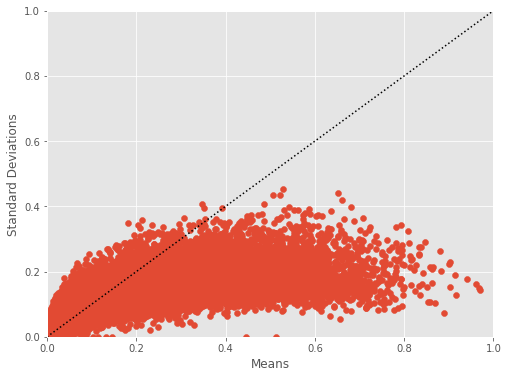

In [35]:
all_means = effnet_genre_mean.values.flatten()
all_stds = effnet_genre_std.values.flatten()

plt.figure(figsize=(8, 6))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(all_means, all_stds)
plt.plot([0, 1],":", c= "black" )
plt.xlabel("Means")
plt.ylabel("Standard Deviations");

The vast majority of means are larger than their standard deviation counterparts, which is preferable. However the standard deviations are a little too high for my liking. It indicates that for a good number of songs the presence of a genre can significantly fluctuate. 

I'm going to keep researching this matter but for the mean time I'll have to stick to taking the mean. 

One idea I do plan on analyzing is taking mean the of the largest N-values in the array. I suspect that a number of songs that clearly belong to one genre have "down" periods where the genre is not detectable or obvious thus depressing the average score. By taking the mean of the 10, 20, or 50 highest scores, I'll be in a way combining mean and max pooling. This idea is based on a hunch but I think it's worthy of testing it.

### The Ear test

Now it's time to audit the effectiveness of the mean scores produced by the effnet model by applying the ear test.

I'm going to rate the quality of the scores in relation to how well they appraise the songs.

But first up, let's look at the genres with the highest scores.

20 highest scoring genres

In [25]:
top20 = effnet_genre_mean.mean().nlargest(20)
top20

electronic___house             0.311761
electronic___disco             0.194238
electronic___nu_disco          0.176342
electronic___deep_house        0.139513
funk__soul___disco             0.103181
funk__soul___funk              0.064297
electronic___synth_pop         0.054941
electronic___downtempo         0.049403
electronic___electro           0.046834
electronic___techno            0.044653
electronic___italo_disco       0.040734
electronic___tech_house        0.036098
funk__soul___boogie            0.034807
electronic___euro_disco        0.028704
electronic___tropical_house    0.028082
electronic___garage_house      0.027401
electronic___italo_house       0.026489
electronic___tribal_house      0.026230
funk__soul___soul              0.025639
electronic___vaporwave         0.024353
dtype: float32

Instead of using the mean of the genre, let's try applying a classification threshold of 0.5 to the scores.

Using this threshold we can tally the genre frequency in the data.

In [26]:
(effnet_genre_mean>=0.5).sum().nlargest(25)

electronic___house               716
electronic___disco               224
electronic___nu_disco            161
funk__soul___disco                61
electronic___deep_house           34
electronic___italo_disco          30
electronic___euro_disco           21
electronic___vaporwave            21
funk__soul___funk                 12
electronic___techno                8
folk_world__country___zouk         8
pop___bubblegum                    8
electronic___italo_house           7
folk_world__country___african      7
electronic___tribal_house          6
funk__soul___boogie                6
electronic___euro_house            5
electronic___tropical_house        5
electronic___garage_house          4
reggae___soca                      4
electronic___synth_pop             3
electronic___synthwave             3
electronic___uk_garage             3
folk_world__country___soukous      3
electronic___new_beat              2
dtype: int64

Visualize the distribution of scores of the top 20 genres.

Here are 20 histograms of activation scores displayed with log scale on the y axis

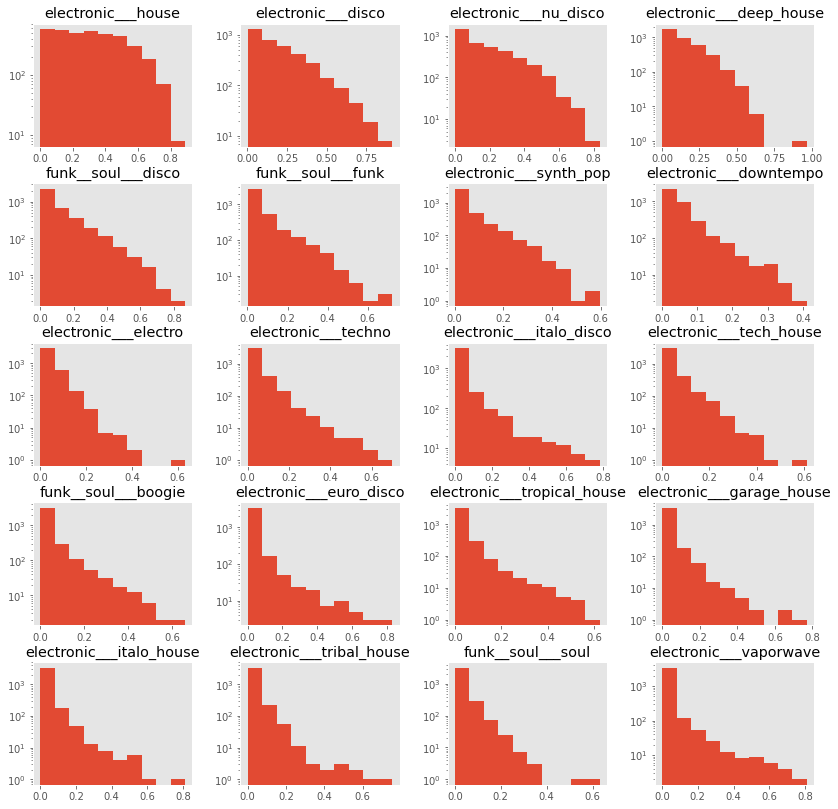

In [36]:
effnet_genre_mean.loc[:, top20.index].hist(figsize =(14, 14), grid = False, log=True);

### Time for the listening test.

I go through several of the genres and listen to a selection of their highest scoring songs. I listen a mix of the more common and rare genres present in my collection.

**Electronic Disco**

Here are the top ten `electronic___disco` songs.

I create a function called `top_songs` to create a dataframe of the top ten songs based on their scores for a specific genre.

In [39]:
top_scores = effnet_genre_mean["electronic___disco"].nlargest(10)
top_scores

sid
068bbbe05d6aaf5fbbee4a89b65eba95    0.915107
NaN                                 0.880775
32dfa61afcde29e346c0e69acde06d42    0.864595
ec4c83b1b9e9056c988fff2c5b70f72f    0.862622
0c25e323e108380754297c1273bf7917    0.851176
190a813d592143fc5b923f9c330ea998    0.837809
1a734b77092397d92fbef3e112bc56b7    0.833462
NaN                                 0.826543
3992e51842f80423b696cb88b329a1d8    0.817392
469dfe1aca4a3383ecee373e1bc3c0d2    0.795834
Name: electronic___disco, dtype: float32

In [37]:
def top_songs(col, n = 10):
    top_scores = effnet_genre_mean[col].nlargest(n)
    return pd.concat([tags, top_scores], axis = 1).dropna(subset=[col])[["title",
                                                               "artist", 
                                                               col]].sort_values(by = col,ascending=False)

In [38]:
top_elec_disco_songs = top_songs("electronic___disco")
top_elec_disco_songs


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

Based on my initial read, this makes sense. I certainly don't dispute disco character of these tracks.

If you'd like to give the ear test a try, listen to the top five songs below.

1. [It's Too Funky In Here - Naughty Daughty](https://www.youtube.com/watch?v=zLAjlx0NfhM)

2. [Estrela Saga - Joutro Mundo](https://www.youtube.com/watch?v=XCkpNH8nu-k)

3. [Friday Night (V4YS Sax & Sun Edit) - Teaspoon & The Waves](https://soundcloud.com/vibes4yoursoul/teaspoon-the-waves-friday-night-v4ys-sax-sun-edit)

4. [Be My Love - Thoma Cher](https://www.youtube.com/watch?v=DCBZWX65zig)

5. [Quero Pouco Quero Muito - Bernardo Pinheiro Edit](https://soundcloud.com/bernardopinheiro/quero-pouco-quero-muito-bernardo-pinheiro-edit)

6. [Let Yourself Be Free (Original Mix)	- The Funk District](https://soundcloud.com/musicdepartmentrussia/premiere-the-funk-district-let-yourself-be-free-sundries)

7. [Freaky Stuff - The Funk District](https://soundcloud.com/furious-mandrill-records/the-funk-district-freaky-stuff-fep001)

8. [Monkey Boogie - Paul Older](https://soundcloud.com/furious-mandrill-records/paul-older-monkey-boogie-fep004)

9. [Timothy's Naked Globe Groove - Sosilly Edits](https://sosilly.bandcamp.com/track/timothys-naked-globe-groove)

10. [Stop The War (V4YS Rework) - Oro](https://soundcloud.com/vibes4yoursoul/oro-stop-the-war-v4ys-rework)


**Electronic House**

In [44]:
col = 'electronic___house'
top_elec_house = top_songs(col)
top_elec_house

,title,artist,electronic___house
sid,,,
570bf0c59d7d80154a24216292db853e,Keep On Luvin (Kingsley's Deep Punch Mix),Maydie Myles,0.890266
f75478ba3c6fc5bb604ccd6c6c0c90fb,Dirty House,Never Dull,0.858027
2f99e8a0e7a31ed2088c916a5bc46329,This Is Real (House mix),JACQUES RENAULT feat ADELINE & MORGAN WILEY,0.853799
f66010e83f2468d18f9513025c17fb67,Norm Talley - If It's Love That U Want,soundsgroovy,0.841303
c2f58ffc6b55da2d7f30468c4ce150bd,C+C Music Factory - Keep It Comin (Erick B Disco Club Mix),OSP Production,0.840663
89798548ebbc71f1ce134556427b20d5,Horny (98 Extended Mix)_PN,"Mousse T, Hot 'N' Juicy",0.816116
d0a1f2f0b76ceff8a9d411096af45896,Infrasoul - So Groovy_PN,None,0.813363
b13d957d6c1fa49aadd3e1c1bbe8216e,Every Night,Munky Fike,0.800369
9f32767c7aba42dae90ba945061028cb,Remember_Da_Name_PN,Giuseppe_Scarano,0.797225


1. [Keep On Luvin (Kingsley's Deep Punch Mix) - Maydie Myles](https://www.youtube.com/watch?v=7rOWAjztKhQ)

2. [Dirty House - Never Dull](https://www.youtube.com/watch?v=UaNZc0QE6CE)

3. [This is Real (House mix) - JACQUES RENAULT feat ADELINE & MORGAN WILEY](https://soundcloud.com/jacques-renault/this-is-real-house-mix-feat)

4. [If it's Love That U Want - Norm Talley](https://www.youtube.com/watch?v=Fh_WHWwVFBg)

5. [Keep It Comin' (Dance Till You Can't Dance No More!) - C + C Music Factory](https://www.youtube.com/watch?v=P4GLT6h6-ko)

6. [Horny '98 (Mousse T.'s Extended Mix) - Mousse T.](https://www.youtube.com/watch?v=A1BK6admJwo)

7. [So Groovy - Infrasoul](https://www.youtube.com/watch?v=6x7VXKSgq-A)

8. [Every Night - Munky Fire](https://soundcloud.com/moskalus/premiere-munky-fike-every-night-thebasement-discos)

9. [Remember Da Name - Giuseppe Scarano](https://www.youtube.com/watch?v=dpzalywwsPg)

10. [You Lied to Me - Nick Garcia](https://houseofboom.bandcamp.com/track/you-lied-to-me)

I was curious to see how well the genre classifier does on more niche genres. So let's evaluate the italo disco zouk, and highlife results.

**Electronic Italo Disco**

In [133]:
col = 'electronic___italo_disco'
top_italo_disco = top_songs(col, n = 5)
top_italo_disco

,title,artist,electronic___italo_disco
sid,,,
8b53723c7985d0d30eafa7235c633f1c,Closed- Crazy Love (Italo Disco),Alberth beat,0.781273
500c71b7dbd6f7c5c25d97420f82f83a,The Rhythm,Black Feeling,0.768296
7d42728b51c32962256218be6baad6b7,G. G. Near - Living In a Rom (Italo Disco 1986),NikoMory Disco80s,0.757695
52e8008549890d7f47c84408755e3fc7,Italo Disco Edits Pt.1 - 01 Brian Martin - Sex...,Captain's Edits,0.715430
a4b15fbca22c96916d0b71e345775cba,Daryl Scott - I Need You Now (Flemming Dalum R...,Flemming Dalum,0.709280


1. [Closed Crazy Love (Italo Disco) - Alberth beat](https://www.youtube.com/watch?v=laIBQwQV0aw)

2. [The Rhythm - Black Feeling](https://www.youtube.com/watch?v=3bopju5zrLc)

3. [G. G. Near - Living In a Rom (Italo Disco 1986) - NikoMory Disco80s](https://www.youtube.com/watch?v=-fmFM6HqRBo)

4. [Sex Tonight - Brian Martin](https://www.youtube.com/watch?v=1oIuCAap4uo)

5. [I Need You Now (Flemming Dalum Remix)](https://www.youtube.com/watch?v=8AkqPXCRRbw)

I have to admit the model did a near perfect job. These 5 songs are quintessential Italo Disco. 

**Folk World Country Zouk**

In [38]:
col = 'folk_world__country___zouk'
top_zouk_songs = top_songs(col, 5)
top_zouk_songs

,title,artist,folk_world__country___zouk
sid,,,
35a175352c9a52b3af976ee2b13e9848,Baume - love Edit #9 - -All Star- - 02 Franck Guiolet - Zouk Pulsions (Nofraje love Edit)_PN,None,0.845613
ccd60fdb29a0e93f78adaf2bc5f54e76,Konpwenn (Phil Mill Edit),Phil_Mill,0.808196
4e0e03ba7f1a23be9835b7ad324e2fa9,Francky Vincent - Fruit de la Passion (Sibu & Joe Nagall edit)-,Sibu,0.792498
f0fc0ab74ba573b6e149b5850a63e621,Battery Cremil - Len Mou Raid (Sibu & Joe Nagall edit),Sibu,0.780594
12c7fde3c3789121ed879184465c1f29,Risqué Zouk,PJ,0.733380


1. [Zouk Pulsions (Nofraje Love Edit) - Frank Guiolet](https://www.youtube.com/watch?v=VJIm8R15xuM)

2. [Konpwenn (Phil Mill Edit) - Phil_Mill](https://soundcloud.com/phil_mill/konpwenn-phil-mill-edit)

3. [Fruit de la Passion (Sibu & Joe Nagall edit) - Francky Vincent](https://sibu.bandcamp.com/track/francky-vincent-fruit-de-la-passion-sibu-joe-nagall-edit-2)

4. [Len Mou Raid (Sibu & Joe Nagall edit) - Battery Cremil](https://sibu.bandcamp.com/track/battery-cremil-len-mou-raid-sibu-joe-nagall-edit-2)

5. [Risque Zouk - PJ](https://heatwavela.bandcamp.com/track/risqu-zouk)

Like Italo Disco, the model did a fantastic job with the Zouk songs.

**Folk World Country Highlife**

Highlife is a subgenre of boogie/disco originating from Ghana. It's one of my favorite genres to spin at gig.

In [50]:
col = "folk_world__country___highlife"
top_highlife_songs = top_songs(col, 5)
top_highlife_songs

,title,artist,folk_world__country___highlife
sid,,,
41e686375434a91d99d8947b527d17d1,Otan Hunu,Slim Young,0.654223
5c4b0c4f157cef4bb33db59c516a355b,Africa (My No. 1),General Ehi Duncan & The Africa Army Express,0.474241
d61ea66f329ff3c6c4cede0058eeb243,Akoko Ba (1986 Funk version),Gyedu Blay Ambolley,0.461084
354a9f6555dcb5b48153fb70615eadae,"Zik Emmy ""Feel Alright"" - Coconut LP, Nigeria 1987 - SOLD",Magic Teapot Records,0.399110
d8dce56d82149356c54d99a711f8da1e,Greetings,Joni Haastrup,0.353992


1. [Otan Hunu - Slim Young](https://www.youtube.com/watch?v=SW86aHpfTwg)

2. [Africa (My No. 1) - General Ehi Duncan & The Africa Army Express](https://www.youtube.com/watch?v=YkU983mVWrA)

3. [Akoko Ba (1986 Funk version) - Gyedu Blay Ambolley](https://www.youtube.com/watch?v=Cc3Lno-Dhag)

4. [Feel Alright - Zik Emmy](https://www.youtube.com/watch?v=_EGzZc3A5Ec)

5. [Greetings - Joni Haastrup](https://www.youtube.com/watch?v=yhq9nC4lrwM)

While these five songs are undisputedly highlife, the low scores are concerning. Using an activation threshold of 0.5 would mean 4/5 of these songs would not make the mark.

I can say that based on a cursory evaluation I am more than satisifed with the quality of the predictions. I think for the most part, the songs I tested exhibited a worthiness of their genre scores.


I'll continue to add update this notebook with other genres. But for now I do want to move onto the other data in the database.